In [1]:
import json
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
from scipy.stats import *
from collections import defaultdict
from utils import *
from search_engine import *
from numpy.random import choice
from tqdm.notebook import tqdm

np.set_printoptions(precision=3)

In [2]:
path_log = './data/log.2.tsv'
path_topic = './data/topic.tsv'
path_sub_topic = './data/sub_topic.tsv'
path_retrievable_paragraph = './data/retrievable_paragraph.tsv'

In [3]:
session_ids = get_session_ids(path_log)
all_sequences = get_all_sequences(path_log, session_ids)

In [4]:
topics = get_topics(path_topic)

topics

{1: 'harvard university',
 2: 'black death',
 3: 'intergovernmental panel on climate change',
 4: 'private schools',
 5: 'geology',
 6: 'economic inequality',
 7: 'immune system',
 8: 'oxygen',
 9: 'normans',
 10: 'amazon rainforest',
 11: 'european union law'}

In [5]:
# topic -> sub_topic -> queries
all_queries = {}

for topic in all_sequences:
    
    queries = defaultdict(list)
    for sequence in all_sequences[topic]:
        for action in sequence:
            sub_topic = action[3]
            query = action[4]
            queries[sub_topic].append(query)
    
    all_queries[topic] = queries

#all_queries

In [6]:
# topic -> sub_topic -> paragraphs
qrels = defaultdict(dict)

sub_topic_to_paragraph = defaultdict(set)
with open(path_retrievable_paragraph) as f:
    for line in f.readlines()[1:]:
        items = line.split('\t')
        sub_topic = int(items[0])
        paragraph = int(items[1])
        sub_topic_to_paragraph[sub_topic].add(paragraph)

sub_topics = get_sub_topics(path_sub_topic)

for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        qrels[topic][sub_topic] = sub_topic_to_paragraph[sub_topic]

#qrels

In [7]:
# from users
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if rel == 'relevant':
                if topic not in qrels_users:
                    qrels_users[topic] = {}
                if sub_topic not in qrels_users[topic]:
                    qrels_users[topic][sub_topic] = set()
                qrels_users[topic][sub_topic].add(paragraph)

#qrels_users

In [8]:
# from users
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if topic not in qrels_users:
                qrels_users[topic] = {}
            if sub_topic not in qrels_users[topic]:
                qrels_users[topic][sub_topic] = {}
            if paragraph not in qrels_users[topic][sub_topic]:
                qrels_users[topic][sub_topic][paragraph] = (0, 0)
            num, den = qrels_users[topic][sub_topic][paragraph]
            if rel == 'relevant':
                qrels_users[topic][sub_topic][paragraph] = (num + 1, den + 1)
            else:
                qrels_users[topic][sub_topic][paragraph] = (num, den + 1)

for topic in qrels_users:
    for sub_topic in qrels_users[topic]:
        for paragraph in qrels_users[topic][sub_topic]:
            num, den = qrels_users[topic][sub_topic][paragraph]
            qrels_users[topic][sub_topic][paragraph] = num/den
            
#qrels_users

In [9]:
direct_index = DirectIndex.load()

In [10]:
set(choice(list(range(10)), replace=False, size = int(len(range(10)) * 0.5)))

{0, 3, 6, 7, 9}

In [11]:
pre_preocessor = PreProcessor()

def select_random_documents(documents:set, p:float=0.0):
    assert(0.0 <= p <= 1.0)
    if p == 0.0:
        return set()
    elif p == 1.0:
        return documents
    else:
        return set(choice(list(documents), replace=False, size = int(len(documents) * p)))
        
def get_search_engine(topic, sub_topic, qrels, direct_index, noise = 0.0):
    # select documents belonging to the topic
    selected_documents = {}
    for document in qrels[topic][sub_topic]:
        selected_documents[document] = direct_index.index[document]
        
    # select random documents
    # 1. from topic documents
    topic_documents = set()
    for _, sub_topic_documents in qrels[topic].items():
        topic_documents.update(sub_topic_documents)    
    topic_documents = select_random_documents(topic_documents, noise)
    
    for document in topic_documents:
        selected_documents[document] = direct_index.index[document]
    
    # 2. from all_documents
    all_documents = direct_index.index.keys()
    all_documents = select_random_documents(all_documents, noise)

    for document in all_documents:
        selected_documents[document] = direct_index.index[document]
        
    # retrievable documents
    inverted_index = InvertedIndex()
    inverted_index.create(selected_documents)
        
    return selected_documents, inverted_index

# stats
inverted_index = InvertedIndex()
inverted_index.create(direct_index.index)

# test
for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        print(topic, topics[topic], sub_topic)
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, 0.01)
        print("over", len(r_documents), "documents")
        r_inverted_index.cl = inverted_index.cl
        r_inverted_index.dictionary = inverted_index.dictionary
        search = Search(r_inverted_index, pre_preocessor)
        print(search.search('amazon', n=2, retrievable_paragraphs=r_documents.keys()))
    break

10 amazon rainforest 1
over 204 documents
[374, 149]
10 amazon rainforest 2
over 203 documents
[371, 381]
10 amazon rainforest 3
over 205 documents
[381, 379]
10 amazon rainforest 4
over 204 documents
[386, 380]
10 amazon rainforest 5
over 203 documents
[371, 54]


In [12]:

# CP

def dd_cp(alpha, m, l):
    return 1

def dd_ncp(alpha, m, l):
    return 1/l

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_cp(None, None, None)
    return res/len(sequence)

def get_ncp_list(sequences):
    res = []
    for sequence in sequences:
        res.append(ncp(sequence))
    return res

# CBP

def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    norm = 0.0
    for i in range(l):
        norm += dd_cbp(alpha, i, l)
    return dd_cbp(alpha, m, l) / norm

def ncbp(sequence, alpha):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# CBP +

def dd_ncbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha, i)
    return res/norm

def ncbp_p(sequence, alpha, beta):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp_p(alpha, beta, m, sequence)
    return res

def get_ncbp_p_list(sequences, alpha, beta):
    res = []
    for sequence in sequences:
        res.append(ncbp_p(sequence, alpha, beta))
    return res

In [13]:
ncbp_p_scores = []
ncbp_scores = []
ncp_scores = []

for topic in topics:
    sequences = all_sequences[topic]
    ncbp_p_scores.append((topic, np.mean(get_ncbp_p_list(sequences, 1.0, 0.32))))
    ncbp_scores.append((topic, np.mean(get_ncbp_list(sequences, 0.79))))
    ncp_scores.append((topic, np.mean(get_ncp_list(sequences))))
    
ncbp_p_scores = sorted(ncbp_p_scores)
ncbp_scores = sorted(ncbp_scores)
ncp_scores = sorted(ncp_scores)

ncbp_p_scores, ncbp_scores, ncp_scores

([(1, 0.48598495253333335),
  (2, 0.7245402721088434),
  (3, 0.8613003663003662),
  (4, 0.5472815345025279),
  (5, 0.3364321794779211),
  (6, 0.642563116883117),
  (7, 0.7394005012531328),
  (8, 0.45797078978234923),
  (9, 0.7591999041239462),
  (10, 0.7321888384625154),
  (11, 0.6494714074074074)],
 [(1, 0.6948132344457122),
  (2, 0.8791838367018248),
  (3, 0.9021250402482669),
  (4, 0.7157422331257991),
  (5, 0.567897587303366),
  (6, 0.8095286053912288),
  (7, 0.8461916634617963),
  (8, 0.6376887986533195),
  (9, 0.8774625265738412),
  (10, 0.8783735656195284),
  (11, 0.8046611482436372)],
 [(1, 0.7194444444444444),
  (2, 0.8677862811791384),
  (3, 0.8874542124542124),
  (4, 0.7112874779541445),
  (5, 0.5482839624143971),
  (6, 0.812987012987013),
  (7, 0.8398496240601504),
  (8, 0.6008454106280192),
  (9, 0.8604978354978355),
  (10, 0.8352598019264688),
  (11, 0.8098653198653198)])

In [14]:
# new version
def get_satisfaction(lines):
    reg_exp = RegExp()
    satisfaction = None
    for line in lines:
        items = line.split('\t')
        content = items[2]
        if reg_exp.get(r'user is (.+)', content):
            satisfaction = reg_exp.res
    return satisfaction

# new
def get_all_satisfactions(path_log, session_ids):
    res = defaultdict(list)
    for session_id in session_ids:
        selected_lines = []
        with open(path_log) as f:
            for line in f.readlines()[1:]:
                items = line.split('\t')
                user = items[3].strip()
                topic = int(items[4].strip())
                if user == session_id[0] and topic == session_id[1]:
                    selected_lines.append(line)

        satisfaction = get_satisfaction(selected_lines)
        res[session_id[1]].append(satisfaction)
    return res

all_satisfactions = get_all_satisfactions(path_log, session_ids)
#all_satisfactions

In [15]:
satisfaction_scores = []
for topic in topics:
    satisfactions = all_satisfactions[topic]
    satisfaction_score = 0.0
    for satisfaction in satisfactions:
        if satisfaction == 'satisfied':
            satisfaction_score += 1
    satisfaction_score /= len(satisfactions)
    satisfaction_scores.append((topic, satisfaction_score))

satisfaction_scores = sorted(satisfaction_scores)
satisfaction_scores

[(1, 0.6666666666666666),
 (2, 0.7857142857142857),
 (3, 0.8846153846153846),
 (4, 0.7407407407407407),
 (5, 0.5217391304347826),
 (6, 0.7727272727272727),
 (7, 0.8421052631578947),
 (8, 0.5217391304347826),
 (9, 0.7368421052631579),
 (10, 0.7407407407407407),
 (11, 0.7333333333333333)]

KendalltauResult(correlation=0.6482593132545565, pvalue=0.006117582447622464)
SpearmanrResult(correlation=0.7625650275119625, pvalue=0.006350520569425186)
(0.8957750450687809, 0.000191506771888404)


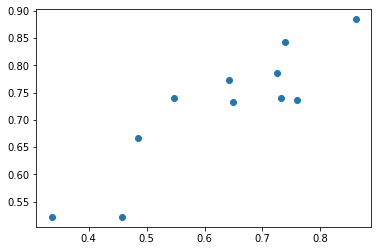

In [16]:
plt.plot([i[1] for i in ncbp_p_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in ncbp_p_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in ncbp_p_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in ncbp_p_scores], [i[1] for i in satisfaction_scores]))

KendalltauResult(correlation=0.7223460919122202, pvalue=0.002252739154933953)
SpearmanrResult(correlation=0.831058892258546, pvalue=0.0015265983452635986)
(0.8808739887980555, 0.0003417224415667421)


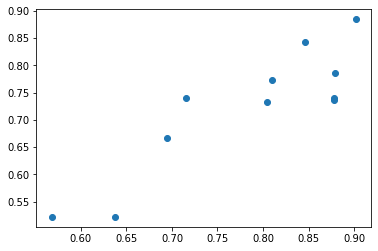

In [17]:
plt.plot([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores]))

KendalltauResult(correlation=0.6853027025833884, pvalue=0.0037547436251961193)
SpearmanrResult(correlation=0.8173601193092295, pvalue=0.002123165628965581)
(0.9157449250833796, 7.57466248948151e-05)


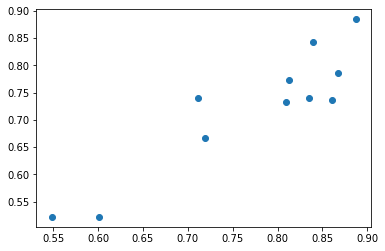

In [18]:
plt.plot([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))

In [19]:
for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        print(topic, topics[topic], sub_topic)
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, inverted_index, 0.0)
        r_inverted_index.cl = inverted_index.cl
        r_inverted_index.dictionary = inverted_index.dictionary
        search = Search(r_inverted_index, pre_preocessor)
        print(search.search('amazon', n=2, retrievable_paragraphs=r_documents.keys()))
    break

10 amazon rainforest 1
[372]
10 amazon rainforest 2
[371]
10 amazon rainforest 3
[379]
10 amazon rainforest 4
[385]
10 amazon rainforest 5
[371]


In [20]:
def generate_sequence(num_subtopics, min_sub_topics = 1):
    prob = 1.0
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 1), 1)[0]
    prob *= 1.0/num_subtopics
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1)[0]
        prob *= 1.0/(num_subtopics + 1)
        sequence.append((current_subtopic + min_sub_topics - 1, None, None, next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
        
    return sequence, prob

sequence, prob = generate_sequence(5)

print(sequence)

print(sequence[:-1])

[(0, None, None, 4, None), (4, None, None, 4, None), (4, None, None, 3, None), (3, None, None, 2, None), (2, None, None, 1, None), (1, None, None, 6, None)]
[(0, None, None, 4, None), (4, None, None, 4, None), (4, None, None, 3, None), (3, None, None, 2, None), (2, None, None, 1, None)]


In [32]:
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.
sampling_size = 5000

def get_uniform_sim(dd):
    topic_scores = []
    for topic in tqdm(topics):
        num_subtopics = len(sub_topics[topic])

        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index

        scores = []
        for n in range(sampling_size):
            sequence, prob = generate_sequence(num_subtopics, min(sub_topics[topic]))

            score = 0.0
            for m, action in enumerate(sequence[:-1]):
                sub_topic = action[3]
                query = action[4]

                query = ''
                if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                    queries = list(all_queries[topic][sub_topic])
                    query = queries[choice(range(len(queries)))]

                search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                rel = 0.0
                if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic]:
                    rel = qrels_users[topic][sub_topic][answer]

                score += dd(0.79, m, len(sequence[:-1])) * rel
                
            scores.append(score)

        if scores:
            scores = np.array(scores)
            topic_score = np.mean(scores)
            topic_scores.append((topic, topic_score))
        else:
            topic_scores.append((topic, 0.0))

    return sorted(topic_scores)

In [ ]:
uniform_sim_system_ncp = get_uniform_sim(lambda alpha, m, l : dd_ncp(alpha, m, l))

In [26]:
uniform_sim_system_ncbp = get_uniform_sim(lambda alpha, m, l : dd_ncbp(alpha, m, l))

In [31]:
#uniform_sim_system_ncp, uniform_sim_system_ncbp

In [27]:
print(kendalltau([i[1] for i in uniform_sim_system_ncp], [i[1] for i in satisfaction_scores]))
print(kendalltau([i[1] for i in uniform_sim_system_ncbp], [i[1] for i in satisfaction_scores]))

KendalltauResult(correlation=0.6482593132545565, pvalue=0.006117582447622464)
KendalltauResult(correlation=0.6482593132545565, pvalue=0.006117582447622464)


In [29]:
print(kendalltau([i[1] for i in ncp_scores], [i[1] for i in uniform_sim_system_ncp]))
print(kendalltau([i[1] for i in ncbp_scores], [i[1] for i in uniform_sim_system_ncp]))
print(kendalltau([i[1] for i in ncbp_p_scores], [i[1] for i in uniform_sim_system_ncp]))

print(kendalltau([i[1] for i in ncp_scores], [i[1] for i in uniform_sim_system_ncbp]))
print(kendalltau([i[1] for i in ncbp_scores], [i[1] for i in uniform_sim_system_ncbp]))
print(kendalltau([i[1] for i in ncbp_p_scores], [i[1] for i in uniform_sim_system_ncbp]))

KendalltauResult(correlation=0.6727272727272727, pvalue=0.0031063111271444604)
KendalltauResult(correlation=0.5636363636363636, pvalue=0.016540504248837583)
KendalltauResult(correlation=0.6363636363636364, pvalue=0.005707170915504249)
KendalltauResult(correlation=0.6727272727272727, pvalue=0.0031063111271444604)
KendalltauResult(correlation=0.5636363636363636, pvalue=0.016540504248837583)
KendalltauResult(correlation=0.6363636363636364, pvalue=0.005707170915504249)


KendalltauResult(correlation=0.8181818181818182, pvalue=0.00013227513227513228)


In [24]:
#plt.plot([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))

KendalltauResult(correlation=0.4720343200308506, pvalue=0.04833991683905927)


In [71]:
def get_transitions_table(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    transitions_table = defaultdict(float)
    for sequence in sequences:
        last_key = None
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            transitions_table[key] += 1
            last_key = key
        transitions_table[(last_key[1], num_subtopics+1)] += 1
    
    norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):            
            transitions_table[(from_subtopic, to_subtopic)] += epsilon
        norms[from_subtopic] += transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if norms[from_subtopic] > 0.0:
            transitions_table[(from_subtopic, to_subtopic)] /= norms[from_subtopic]
            
    return transitions_table

#get_transitions_table(len(sub_topics[1]), min(sub_topics[1]), all_sequences[1])

def generate_sequence_from_table(num_subtopics, min_sub_topics, table):
    prob = 1.0
    table = to_matrix(table)
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[0])[0]
    prob *= table[0, next_subtopic - 1]
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[current_subtopic])[0]
        prob *= table[current_subtopic, next_subtopic-1]
        sequence.append((current_subtopic + min_sub_topics - 1, None, None, next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
    
    return sequence, prob
    
transitions_table = get_transitions_table(len(sub_topics[1]), min(sub_topics[1]), all_sequences[1])
#generate_sequence_from_table(len(sub_topics[1]), min(sub_topics[1]), transitions_table)

In [27]:
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.

sampling_size = 5000

topic_scores = []
for topic in tqdm(topics):
    num_subtopics = len(sub_topics[topic])

    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    transitions_table = get_transitions_table(num_subtopics, min(sub_topics[topic]), all_sequences[topic])

    scores = []
    for n in range(sampling_size):
        sequence, prob = generate_sequence_from_table(num_subtopics, min(sub_topics[topic]), transitions_table)

        score = 0.0
        for m, action in enumerate(sequence[:-1]):
            sub_topic = action[3]
            query = action[4]

            query = ''
            if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                queries = list(all_queries[topic][sub_topic])
                query = queries[choice(range(len(queries)))]

            search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
            answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

            rel = 0.0
            if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic]:
                rel = qrels_users[topic][sub_topic][answer]

            #score += 1 *  #dd_ncbp(0.8, m, len(sequence[:-1]))
            #score += dd_cbp_p(1, 0.67, m, sequence)
            #score += dd_cp(sequence) * rel
            score += dd_ncbp(0.8, m, len(sequence[:-1])) * rel
            
        scores.append(score)

    if scores:
        scores = np.array(scores)
        topic_score = np.mean(scores)
        topic_scores.append((topic, topic_score))
    else:
        topic_scores.append((topic, 0.0))

table_sim_system_scores = sorted(topic_scores)
list(zip(table_sim_system_scores, ncbp_scores))

[((1, 0.8162941742206982), (1, 0.7799641374746731)),
 ((2, 0.8763218452751548), (2, 0.8745853438757577)),
 ((3, 0.894629902347133), (3, 0.8945038856320807)),
 ((4, 0.5325909577523417), (4, 0.6005342526375882)),
 ((5, 0.37745821213763786), (5, 0.3593291485479703)),
 ((6, 0.7830627022790169), (6, 0.7882732571209181)),
 ((7, 0.8648019685477608), (7, 0.876525852719441)),
 ((8, 0.5458108598502371), (8, 0.641354165804504)),
 ((9, 0.8481337366242809), (9, 0.8476545974578821)),
 ((10, 0.7601370822719049), (10, 0.8426307897789052)),
 ((11, 0.7278309317477643), (11, 0.7100540197214268))]

In [28]:
#plt.plot([i[1] for i in uniform_sim_system_scores], [i[1] for i in table_sim_system_scores], 'o')
print(kendalltau([i[1] for i in uniform_sim_system_scores], [i[1] for i in table_sim_system_scores]))

KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)


In [29]:
#plt.plot([i[1] for i in ncp_scores], [i[1] for i in table_sim_system_scores], 'o')
print(kendalltau([i[1] for i in ncp_scores], [i[1] for i in table_sim_system_scores]))

KendalltauResult(correlation=0.9272727272727274, pvalue=3.2567740901074234e-06)


In [30]:
#plt.plot([i[1] for i in ncbp_scores], [i[1] for i in table_sim_system_scores], 'o')
print(kendalltau([i[1] for i in ncbp_scores], [i[1] for i in table_sim_system_scores]))

KendalltauResult(correlation=0.8545454545454545, pvalue=4.624619207952541e-05)


KendalltauResult(correlation=0.4720343200308506, pvalue=0.04833991683905927)


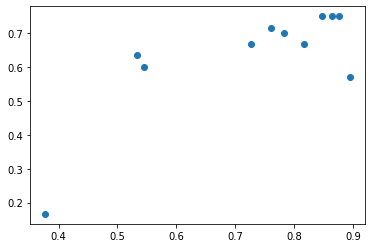

In [31]:
plt.plot([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores]))

In [58]:
def get_transitions_tables(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    rel_transitions_table = defaultdict(float)
    irr_transitions_table = defaultdict(float)
    p_rel = defaultdict(float)
    p_irr = defaultdict(float)
    for sequence in sequences:
        last_key = None
        last_rel = 'irrelevant'
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            if last_rel == 'relevant':
                rel_transitions_table[key] += 1
                p_rel[key[0]] += 1
            else:
                irr_transitions_table[key] += 1
                p_irr[key[0]] += 1
            last_key = key
            last_rel = action[2]
        
        if last_rel == 'relevant':
            rel_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_rel[last_key[1]] += 1
        else:
            irr_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_irr[last_key[1]] += 1
        
    rel_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if from_subtopic > 0:            
            rel_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        rel_norms[from_subtopic] += rel_transitions_table[(from_subtopic, to_subtopic)]
    
    irr_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):
            irr_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        irr_norms[from_subtopic] += irr_transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if rel_norms[from_subtopic] > 0.0:
            rel_transitions_table[(from_subtopic, to_subtopic)] /= (rel_norms[from_subtopic]) 
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if irr_norms[from_subtopic] > 0.0:
            irr_transitions_table[(from_subtopic, to_subtopic)] /= (irr_norms[from_subtopic])
    
    p = []
    for t in range(num_subtopics + 1):
        if (p_rel[t] + p_irr[t]) > 0:
            p.append(p_rel[t]/(p_rel[t] + p_irr[t]))
        else:
            p.append(0.0)
    p = np.array([p])

    return rel_transitions_table, irr_transitions_table, p, 1 - p

t1, t2, p_rel, p_irr = get_transitions_tables(len(sub_topics[1]), min(sub_topics[1]), all_sequences[1], 0.0)

#print(p_rel, p_irr)
#print(to_matrix(transitions_table))
print(to_matrix(t1)) 
print(to_matrix(t2))
#print((to_matrix(t1).T * p_rel).T + (to_matrix(t2).T * p_irr).T)

[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.222 0.222 0.111 0.333 0.111]
 [0.167 0.    0.167 0.5   0.    0.167]
 [0.154 0.154 0.    0.231 0.154 0.308]
 [0.3   0.1   0.4   0.    0.2   0.   ]
 [0.    0.222 0.222 0.222 0.    0.333]]
[[0.167 0.    0.583 0.    0.25  0.   ]
 [0.    0.    0.    0.    0.    1.   ]
 [0.    0.5   0.    0.    0.5   0.   ]
 [0.    0.167 0.5   0.167 0.    0.167]
 [0.    0.    0.    0.    0.    0.   ]
 [0.4   0.    0.    0.    0.4   0.2  ]]


In [34]:
class SequenceGenerator:
    
    def __init__(self, num_subtopics, min_sub_topic, rel_table, irr_table):
        self.num_subtopics = num_subtopics
        self.rel_table = to_matrix(rel_table)
        self.irr_table = to_matrix(irr_table)
        self.min_sub_topic = min_sub_topic
        self.relevance = False
        self.current_subtopic = 0
        
    def __iter__(self):
        #self.current_subtopic = 0
        return self
    
    def set_relevance(self, relevance):
        self.relevance = relevance
    
    def __next__(self):
        next_subtopic = -1
        prob = -1
        if self.current_subtopic + self.min_sub_topic - 1 == self.num_subtopics + 1 + self.min_sub_topic - 1:
            raise StopIteration
        if self.relevance:
            #print(self.rel_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 1, p=self.rel_table[self.current_subtopic])[0]
            prob = self.rel_table[self.current_subtopic, next_subtopic - 1]
        else:
            #print(self.irr_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 1, p=self.irr_table[self.current_subtopic])[0]
            prob = self.irr_table[self.current_subtopic, next_subtopic - 1]
        self.current_subtopic = next_subtopic
        return next_subtopic + self.min_sub_topic - 1, prob
    
sg = SequenceGenerator(len(sub_topics[1]), min(sub_topics[1]), t1, t2)
for i in sg:
    print(i)
    sg.set_relevance(True)

(39, 0.5833333333333334)
(38, 0.15384615384615385)
(40, 0.5)
(39, 0.4)
(42, 0.3076923076923077)


# Simulations

In [133]:
def ltse(d1, d2):
    err = 0.0
    M = len(d1)
    if len(d1) < len(d2):
        d1, d2 = d2, d1
    for i in range(len(d1)):
        if i < len(d2):
            err += abs(d1[i]-d2[i])**2   
        else:
            err += abs(d1[i])**2
    return np.log(err)

In [134]:
gp = defaultdict(int)
for topic in all_sequences:
    for sequence in all_sequences[topic]:
        for m, _ in enumerate(sequence):
            gp[m] += 1

ngp = np.array([value for key, value in gp.items()])
ngp = ngp / np.sum(ngp)

ngp

array([0.203, 0.165, 0.158, 0.141, 0.115, 0.078, 0.052, 0.033, 0.022,
       0.011, 0.008, 0.005, 0.005, 0.003, 0.002])

## Uniform Simulations

In [135]:
num_samples = 1000

In [136]:
def get_uniform_dist(alpha, dd):
    res = defaultdict(float)
    norm = defaultdict(float)
    for topic in sub_topics:
        for _ in range(num_samples):
            sequence, _ = generate_sequence(len(sub_topics[topic]), min(sub_topics[topic]))
            for m, _ in enumerate(sequence[:-1]):
                res[m] += dd(alpha, m, len(sequence[:-1]))
                norm[m] += 1
    
    for m in res:
        res[m] /= norm[m]
    
    nres = np.array([value for key, value in res.items()])
    nres = nres / np.sum(nres)
    return nres

def dd_cbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    return res

def get_uniform_dist2(alpha, beta):
    res = defaultdict(float)
    norm = defaultdict(float)
    for topic in sub_topics:
        
        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index
            
        for _ in range(num_samples):
            sequence, _ = generate_sequence(len(sub_topics[topic]), min(sub_topics[topic]))
            for m, action in enumerate(sequence[:-1]):
                query = ''
                if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                    queries = list(all_queries[topic][sub_topic])
                    query = queries[choice(range(len(queries)))]

                search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                    sequence[m] = (action[0], action[1], 'relevant', action[3], action[4])
                else:
                    sequence[m] = (action[0], action[1], 'irrelevant', action[3], action[4])
                
                res[m] += dd_cbp_p(alpha, beta, m, sequence[:-1])
                norm[m] += 1
    
    for m in res:
        res[m] /= norm[m]
    
    nres = np.array([value for key, value in res.items()])
    nres = nres / np.sum(nres)
    return nres

In [137]:
ngp_u_cp = get_uniform_dist(0.0, lambda alpha, m, l : 1)
print("CP, LTSE", ltse(ngp, ngp_u_cp))

CP, LTSE -2.0535721483461167


In [138]:
res = 100
max_alpha = 0.0
max_lmse = 0.0
ngp_u_cbp = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    ngp_u = get_uniform_dist(alpha, lambda alpha, m, l : alpha**m)
            
    score = ltse(ngp, ngp_u)
    if score < max_lmse:
        max_lmse = score
        max_alpha = alpha
        ngp_u_cbp = ngp_u
        
print("CBP, LTSE", max_lmse, max_alpha)


CBP, LTSE -5.482890815309449 0.78


In [140]:
res = 100
max_alpha = 0.0
max_beta = 0.0
max_lmse = 0.0
ngp_u_cbp_p = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    for beta in range(res, res+1):
        beta /= res
        
        ngp_u = get_uniform_dist2(alpha, beta)

        score = ltse(ngp, ngp_u)
        if score < max_lmse:
            max_lmse = score
            max_alpha = alpha
            max_beta = beta
            ngp_u_cbp_p = ngp_u
        
print("CBP, LMSE", max_lmse, max_alpha, max_beta)


CBP, LMSE -5.4286815803638655 0.73 1.0


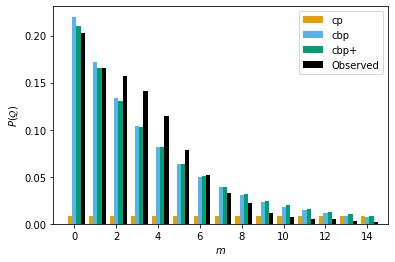

In [141]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_u_cp[0:len(x)], width = bar_width, color='#E69F00', align='center', label='cp')
plt.bar(x+bar_width*0, ngp_u_cbp[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='cbp')
plt.bar(x+bar_width*1, ngp_u_cbp_p[0:len(x)], width = bar_width, color='#009E73', align='center', label="cbp+")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

## Markov Simulations

In [142]:
def get_table_dist(alpha, dd):
    res = defaultdict(int)
    norm = defaultdict(int)
    for topic in sub_topics:
        transitions_table = get_transitions_table(len(sub_topics[topic]), min(sub_topics[topic]), all_sequences[topic])
        for _ in range(num_samples):
            sequence, _ = generate_sequence_from_table(len(sub_topics[topic]), min(sub_topics[topic]), transitions_table)
            for m, _ in enumerate(sequence[:-1]):
                res[m] += dd(alpha, m, len(sequence[:-1]))
                norm[m] += 1

    for m in res:
        res[m] /= norm[m]
        
    nres = np.array([value for key, value in res.items()])
    nres = nres / np.sum(nres)
    return nres

def get_table_dist2(alpha, beta):
    res = defaultdict(int)
    norm = defaultdict(int)
    for topic in sub_topics:
        
        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index
            
        transitions_table = get_transitions_table(len(sub_topics[topic]), min(sub_topics[topic]), all_sequences[topic])

        for _ in range(num_samples):
            sequence, _ = generate_sequence_from_table(len(sub_topics[topic]), min(sub_topics[topic]), transitions_table)
            for m, action in enumerate(sequence[:-1]):
                query = ''
                if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                    queries = list(all_queries[topic][sub_topic])
                    query = queries[choice(range(len(queries)))]

                search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                    sequence[m] = (action[0], action[1], 'relevant', action[3], action[4])
                else:
                    sequence[m] = (action[0], action[1], 'irrelevant', action[3], action[4])
                
                res[m] += dd_cbp_p(alpha, beta, m, sequence[:-1])
                norm[m] += 1
                
    for m in res:
        res[m] /= norm[m]
    
    nres = np.array([value for key, value in res.items()])
    nres = nres / np.sum(nres)
    return nres

In [143]:
ngp_t_cp = get_table_dist(0.0, lambda alpha, m, l : 1)
print("CP, LTSE", ltse(ngp, ngp_t_cp))

CP, LTSE -2.153620235438554


In [144]:
res = 100
max_alpha = 0.0
max_ltse = 0.0
ngp_t_cbp = None
for alpha in tqdm(range(0, res + 1)):
    alpha /= res
    
    ngp_t = get_table_dist(alpha, lambda alpha, m, l : alpha**m)
            
    score = ltse(ngp, ngp_t)
    if score < max_ltse:
        max_ltse = score
        max_alpha = alpha
        ngp_t_cbp = ngp_t
        
print("CBP, LTSE", max_ltse, max_alpha)


CBP, LTSE -5.482905364804946 0.78


In [147]:
res = 10
max_alpha = 0.0
max_beta = 0.0
max_ltse = 0.0
ngp_t_cbp_p = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    for beta in range(0, res+1):
        beta /= res
        
        ngp_t = get_table_dist2(alpha, beta)

        score = ltse(ngp, ngp_t)
        if score < max_ltse:
            max_ltse = score
            max_alpha = alpha
            max_beta = beta
            ngp_t_cbp_p = ngp_t
        
print("CBP, LTSE", max_ltse, max_alpha, max_beta)


CBP, LTSE -5.499153751338099 0.8 0.7


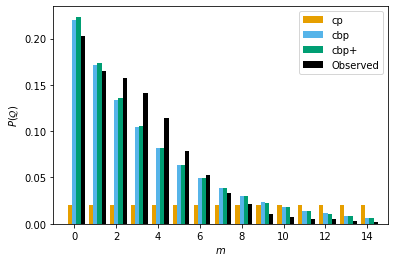

In [148]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_t_cp[0:len(x)], width = bar_width, color='#E69F00', align='center', label='cp')
plt.bar(x+bar_width*0, ngp_t_cbp[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='cbp')
plt.bar(x+bar_width*1, ngp_t_cbp_p[0:len(x)], width = bar_width, color='#009E73', align='center', label="cbp+")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

## Markov + Simulation

In [149]:
def get_double_table_dist(alpha, dd):
    res = defaultdict(float)
    norm = defaultdict(float)
    for topic in sub_topics:
        num_subtopics = len(sub_topics[topic])

        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index

        rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, min(sub_topics[topic]), all_sequences[topic], 0.0001)

        for _ in range(num_samples):
            sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
            for m, (sub_topic, _) in enumerate(sg):
                if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                    query = ''
                    if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                        queries = list(all_queries[topic][sub_topic])
                        query = queries[choice(range(len(queries)))]

                    search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                    answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]
                    
                    if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                    else:
                        sg.set_relevance(False)
                        
                    res[m] += dd(alpha, m, len(sequence[:-1]))
                    norm[m] += 1

    for m in res:
        res[m] /= norm[m]
        
    nres = np.array([value for key, value in res.items()])
    nres = nres / np.sum(nres)
    return nres


def get_double_table_dist2(alpha, beta):
    res = defaultdict(float) 
    norm = defaultdict(float) 
    
    for topic in sub_topics:
        num_subtopics = len(sub_topics[topic])

        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index

        rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, min(sub_topics[topic]), all_sequences[topic], 0.001)

        for _ in range(num_samples):
            sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
            sequence = []
            for m, (sub_topic, _) in enumerate(sg):
                if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                    query = ''
                    if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                        queries = list(all_queries[topic][sub_topic])
                        query = queries[choice(range(len(queries)))]

                    search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                    answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]
                    
                    if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                        sequence.append((None, None, 'relevant', None, None))
                    else:
                        sg.set_relevance(False)
                        sequence.append((None, None, 'irrelevant', None, None))

                    res[m] += dd_cbp_p(alpha, beta, m, sequence)
                    norm[m] += 1

    for m in res:
        res[m] /= norm[m]

    nres = np.array([value for key, value in res.items()])
    nres = nres / np.sum(nres)
    return nres

In [150]:
ngp_t2_cp = get_double_table_dist(None, lambda alpha, m, l : 1)
print("CP, LTSE", ltse(ngp, ngp_t2_cp))

CP, LTSE -2.1614551910283293


In [151]:
res = 100
max_alpha = 0.0
max_ltse = 0.0
ngp_t2_cbp = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    ngp_t2 = get_double_table_dist(alpha, lambda alpha, m, l : alpha**m)
            
    score = ltse(ngp, ngp_t2)
    if score < max_ltse:
        max_ltse = score
        max_alpha = alpha
        ngp_t2_cbp = ngp_t2
        
print("CBP, LMSE", max_lmse, max_alpha)


CBP, LMSE -5.4286815803638655 0.78


In [ ]:
res = 10
max_alpha = 0.0
max_beta = 0.0
max_ltse = 0.0
ngp_t2_cbp_p = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    for beta in range(0, res+1):
        beta /= res
        
        ngp_t2 = get_double_table_dist2(alpha, beta)

        score = ltse(ngp, ngp_t2)
        if score < max_ltse:
            max_ltse = score
            max_alpha = alpha
            max_beta = beta
            ngp_t2_cbp_p = ngp_t2
        
print("CBP, LMSE", max_ltse, max_alpha, max_beta)

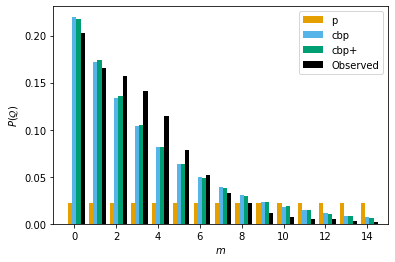

In [153]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_t2_cp[0:len(x)], width = bar_width, color='#E69F00', align='center', label='p')
plt.bar(x+bar_width*0, ngp_t2_cbp[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='cbp')
plt.bar(x+bar_width*1, ngp_t2_cbp_p[0:len(x)], width = bar_width, color='#009E73', align='center', label="cbp+")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

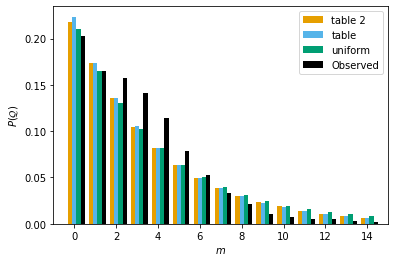

In [155]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_t2_cbp_p[0:len(x)], width = bar_width, color='#E69F00', align='center', label='table 2')
plt.bar(x+bar_width*0, ngp_t_cbp_p[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='table')
plt.bar(x+bar_width*1, ngp_u_cbp_p[0:len(x)], width = bar_width, color='#009E73', align='center', label="uniform")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

# Correlation Analysis with Satisfaction

In [132]:
topic_scores = []
for topic in tqdm(topics):
    num_subtopics = len(sub_topics[topic])

    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    scores = []
    for n in range(num_samples):
        sequence, _ = generate_sequence(len(sub_topics[topic]), min(sub_topics[topic]))

        score = 0.0
        norm = 0.0
        for m, action in enumerate(sequence[:-1]):
            sub_topic = action[3]
            query = action[4]

            query = ''
            if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                queries = list(all_queries[topic][sub_topic])
                query = queries[choice(range(len(queries)))]

            search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
            answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

            rel = 0.0
            if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic]:
                rel = qrels_users[topic][sub_topic][answer]
                
            score += rel
            norm += 1
            
        scores.append(score/norm)

    if scores:
        scores = np.array(scores)
        topic_score = np.mean(scores)
        topic_scores.append((topic, topic_score))
    else:
        topic_scores.append((topic, 0.0))

uniform_sim_system_scores = sorted(topic_scores)
uniform_sim_system_scores

[(1, 0.762770062735889),
 (2, 0.8533936176528112),
 (3, 0.9226404063120115),
 (4, 0.7061487535404528),
 (5, 0.590362376063788),
 (6, 0.7886455248373765),
 (7, 0.8824769683687621),
 (8, 0.6272470146396827),
 (9, 0.7815201481458842),
 (10, 0.7531536996691425),
 (11, 0.8663886612288991)]

KendalltauResult(correlation=0.6482593132545565, pvalue=0.006117582447622464)
SpearmanrResult(correlation=0.7671312851617349, pvalue=0.005860949194525314)
(0.9189546710456666, 6.390226682697633e-05)


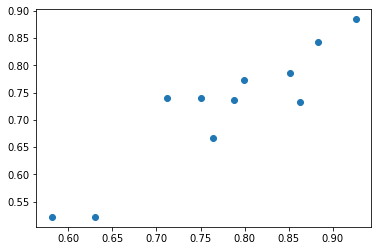

In [109]:
plt.plot([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))

In [ ]:
plt.plot([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))

In [103]:
topic_scores = []
for topic in tqdm(topics):
    num_subtopics = len(sub_topics[topic])

    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    transitions_table = get_transitions_table(num_subtopics, min(sub_topics[topic]), all_sequences[topic])

    scores = []
    for n in range(num_samples):
        sequence, prob = generate_sequence_from_table(num_subtopics, min(sub_topics[topic]), transitions_table)

        score = 0.0
        norm = 0.0
        for m, action in enumerate(sequence[:-1]):
            sub_topic = action[3]
            query = action[4]

            query = ''
            if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                queries = list(all_queries[topic][sub_topic])
                query = queries[choice(range(len(queries)))]

            search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
            answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

            rel = 0.0
            if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic]:
                rel = qrels_users[topic][sub_topic][answer]
                
            score += rel
            norm += 1
            
        scores.append(score/norm)

    if scores:
        scores = np.array(scores)
        topic_score = np.mean(scores)
        topic_scores.append((topic, topic_score))
    else:
        topic_scores.append((topic, 0.0))

table_sim_system_scores = sorted(topic_scores)
table_sim_system_scores

[(1, 0.7264720872542596),
 (2, 0.8578781148805954),
 (3, 0.9071334666396406),
 (4, 0.6157307327499238),
 (5, 0.5769248189116538),
 (6, 0.8227734493139862),
 (7, 0.8694614364638016),
 (8, 0.5701797759243734),
 (9, 0.8282828894937792),
 (10, 0.7424616936825696),
 (11, 0.7825486657272813)]

KendalltauResult(correlation=0.759389481241052, pvalue=0.0013210471654040165)
SpearmanrResult(correlation=0.8630226958069518, pvalue=0.0006236016959127901)
(0.8809872248878505, 0.0003403208798428066)


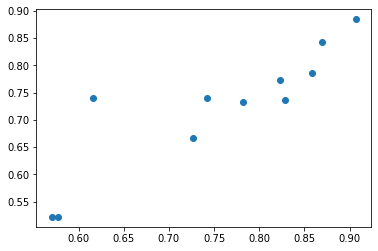

In [104]:
plt.plot([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores]))

In [115]:
topic_scores = []
for topic in tqdm(topics):
    num_subtopics = len(sub_topics[topic])

    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, min(sub_topics[topic]), all_sequences[topic], 0.01)

    # compute metric
    scores = []
    for n in range(num_samples):
        score = 0.0
        norm = 0.0
        sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
        sequence = []
        for m, (sub_topic, prob_subtopic)  in enumerate(sg):
            if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                prob *= prob_subtopic
                is_rel = False
                query = ''
                if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                    queries = list(all_queries[topic][sub_topic])
                    query = queries[choice(range(len(queries)))]

                search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                rel = 0.0
                if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic]:
                    if np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                        sequence.append((None, None, 'relevant', None, None))
                    else:
                        sg.set_relevance(False)
                        sequence.append((None, None, 'irrelevant', None, None))                        
                    rel = qrels_users[topic][sub_topic][answer]
                else:
                    sg.set_relevance(False)
                    sequence.append((None, None, 'irrelevant', None, None))
                
                
                score += rel
                norm += 1

        scores.append(score/norm)

    if scores:
        scores = np.array(scores)
        topic_score = np.mean(scores)
        topic_scores.append((topic, topic_score))
    else:
        topic_scores.append((topic, 0.0))

system_scores = sorted(topic_scores)

system_scores

[(1, 0.7294545180644723),
 (2, 0.8553605773327895),
 (3, 0.8989598675820376),
 (4, 0.6269565321972065),
 (5, 0.5837254402537244),
 (6, 0.8090523639273562),
 (7, 0.863684257095535),
 (8, 0.5652870189989936),
 (9, 0.8362258920955621),
 (10, 0.7357550466760356),
 (11, 0.7814501057105049)]

KendalltauResult(correlation=0.759389481241052, pvalue=0.0013210471654040165)
SpearmanrResult(correlation=0.8630226958069518, pvalue=0.0006236016959127901)
(0.8832298816864123, 0.00031345031993632337)


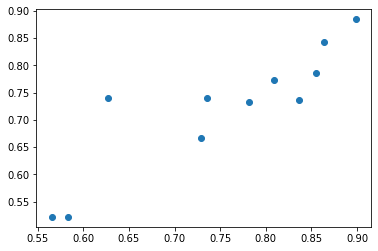

In [116]:
plt.plot([i[1] for i in system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))



KendalltauResult(correlation=0.6727272727272727, pvalue=0.0031063111271444604)
SpearmanrResult(correlation=0.8000000000000002, pvalue=0.0031104283103858483)
(0.8647546896442244, 0.0005904360432073924)


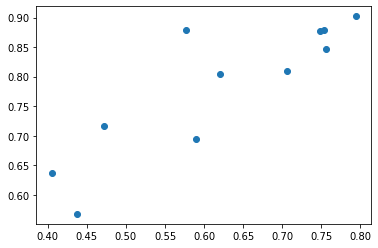

In [113]:
plt.plot([i[1] for i in system_scores], [i[1] for i in ncbp_scores], 'o')
print(kendalltau([i[1] for i in system_scores], [i[1] for i in ncbp_scores]))
print(spearmanr([i[1] for i in system_scores], [i[1] for i in ncbp_scores]))
print(pearsonr([i[1] for i in system_scores], [i[1] for i in ncbp_scores]))

In [57]:
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.
noise = 0.0

means = []
for noise in tqdm(range(0, 11)):
    noise = noise/10

    topic_scores = []

    for topic in topics:
        num_subtopics = len(sub_topics[topic])

        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, noise)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index

        rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, min(sub_topics[topic]), all_sequences[topic], 0.01)

        # compute metric
        scores = []
        for n in range(50):
            score = 0.0
            norm = 0.0
            sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
            sequence = []
            for m, (sub_topic, prob_subtopic)  in enumerate(sg):
                if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                    prob *= prob_subtopic
                    is_rel = False
                    query = ''
                    if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                        queries = list(all_queries[topic][sub_topic])
                        query = queries[choice(range(len(queries)))]

                    search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                    answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                    rel = 0.0
                    if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                        sequence.append((None, None, 'relevant', None, None))
                        rel = qrels_users[topic][sub_topic][answer]
                    else:
                        sg.set_relevance(False)
                        sequence.append((None, None, 'irrelevant', None, None))

                    score += dd_cbp_p(alpha, beta, m, sequence) * rel
                    norm += dd_cbp_p(alpha, beta, m, sequence)
            scores.append(score/norm)

        if scores:
            scores = np.array(scores)
            topic_score = np.mean(scores)
            topic_scores.append(topic_score)
        else:
            topic_scores.append(0.0)

    system_scores = np.mean(topic_scores)
    
    means.append((noise, system_scores))
    
means


[(0.0, 0.5990411683655059),
 (0.1, 0.23892707565406066),
 (0.2, 0.1882925909385129),
 (0.3, 0.11470096829422398),
 (0.4, 0.09781414835830922),
 (0.5, 0.10366885926110005),
 (0.6, 0.08672672279096678),
 (0.7, 0.08140980379790647),
 (0.8, 0.07947905090882018),
 (0.9, 0.08515765405331138),
 (1.0, 0.0766703986810347)]

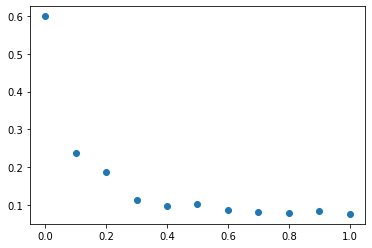

In [58]:
plt.plot([i[0] for i in means], [i[1] for i in means], 'o')

KendalltauResult(correlation=0.5092285591855548, pvalue=0.04625414225661218)


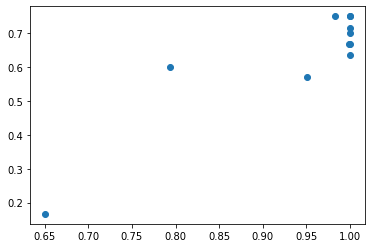

In [230]:
plt.plot([i[1] for i in system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))

KendalltauResult(correlation=0.8499999999999999, pvalue=0.0014534154631930748)


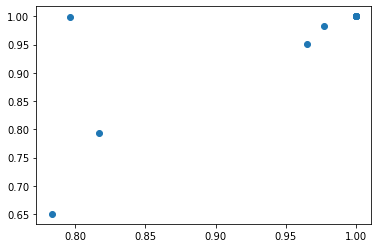

In [231]:
plt.plot([i[1] for i in uniform_sim_system_scores], [i[1] for i in system_scores], 'o')
print(kendalltau([i[1] for i in uniform_sim_system_scores], [i[1] for i in system_scores]))

KendalltauResult(correlation=0.9219544457292885, pvalue=0.0007118113571692198)


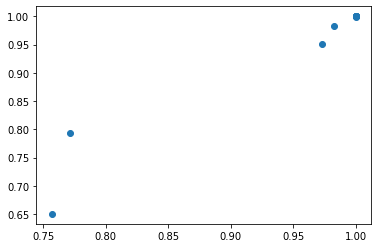

In [232]:
plt.plot([i[1] for i in table_sim_system_scores], [i[1] for i in system_scores], 'o')
print(kendalltau([i[1] for i in table_sim_system_scores], [i[1] for i in system_scores]))

KendalltauResult(correlation=0.5092285591855548, pvalue=0.04625414225661218)


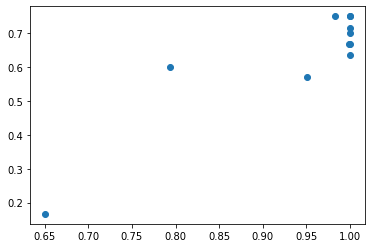

In [233]:
plt.plot([i[1] for i in system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))